# Clustering *League of Legends* Player Decisions by Game State
*League of Legends* is a online game divided into various matches in which teams of players compete against each other to destroy the others bases. The central gameplay loop revolves around completing various objectives in order to acquire gold which players exchange for items that make themselves more powerful. The items purchased by players represent one of the major choices available, as different items grant different powers to players. The purpose of this analysis is to analyze the choices made by those players to see if people actually care enough to vary their purchases relative to the game state, as decided by kill/death ratio as a proxy variable for individual success. Clustering will be done via K-means, and the primary question of this analysis will be identifying if the clusters of item choices correspond to game-states. 

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as met
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

First, we will import our csv from the first notebook, Data_Collection.ipynb. This step has been separated out to remedy the issues with reading Kaggle data from cache, as that's an absolute path. The data includes the champion (the player's character), their role on the team, gameID data, and victory status. After that includes the seven item choices, signified by their four digit item IDs, and one-hot encodings for all the item choices.

In [2]:
items = pd.read_csv("data/encodedLeagueData.csv")
pd.DataFrame.head(items)

,championName,lane,GameID,win,item0,item1,item2,item3,item4,item5,...,7014,7015,7016,7017,7018,7019,7020,7021,7022,8001
0,Trundle,JUNGLE,4035079604,True,3075,2031,3044,3047,6632,1037,...,0,0,0,0,0,0,0,0,0,0
1,Sylas,MIDDLE,4035079604,True,4629,3157,6656,3020,1082,1058,...,0,0,0,0,0,0,0,0,0,0
2,Viego,JUNGLE,4035079604,False,3047,2031,6632,3153,1031,0,...,0,0,0,0,0,0,0,0,0,0
3,Yasuo,MIDDLE,4035079604,False,6333,3006,6673,3031,3072,0,...,0,0,0,0,0,0,0,0,0,0
4,Caitlyn,BOTTOM,4035079604,False,1055,6672,3006,3031,0,0,...,0,0,0,0,0,0,0,0,0,0


The obvious problem with this data is its dimensionality is much higher than its size, which could make clustering difficult. Thankfully, most of those dimensions are probably zero for most champions, since there are a lot of bad choices. We will check that now for an example case for the most popular champion/role combination.

In [3]:
items.groupby(['championName','lane']).count()['GameID'].idxmax()

('Ashe', 'BOTTOM')

In [4]:
ashe = (items[(items['championName']=='Ashe')&(items['lane']=='BOTTOM')].
        drop(columns=['championName','lane','GameID','win','item0','item1','item2','item3','item4','item5','item6','kills','assists','deaths']).
        copy())
(ashe.sum()>0).sum()

np.int64(108)

As we can see, on the most popular champion in her most popular role, only 107 of the items were purchased (KDA column was upheld). This may still be too many dimensions, but we're not going to worry about that right now. Onto clustering, we will be using scikit learns KMeans and varying the only hyperparameter, cluster number, on our Ashe data. Due to the lack of 'true' classifications (ground truth labels), clustering efficacy will have to be measured by either Silhouette Coefficient, Calinski-Harabasz Index, and Davies-Boudin Index. Thankfully, all of these have methods in scikit-learn, which is  

In [28]:
def measurement_testing(X, count, PCAV=False,start=20,step=5):
    accuracies = np.zeros([count,4])
    if PCAV == False:
        clusters = np.arange(count)+2
        for i in clusters:
            kmeans = KMeans(n_clusters=i,random_state=108+i,n_init="auto").fit(X)
            labels=kmeans.labels_
            accuracies[i-2,0]=i
            accuracies[i-2,1]=met.silhouette_score(X, labels, metric='euclidean')
            accuracies[i-2,2]=met.calinski_harabasz_score(X, labels)
            accuracies[i-2,3]=met.davies_bouldin_score(X, labels)
        return accuracies
    else:
        PCAtypes = np.arange(start,step*count+start,step)
        lp = 0
        for i in PCAtypes:
            pca = PCA(n_components=i).fit(X)
            PCAtest = pca.transform(X)
            kmeans = KMeans(n_clusters=4,random_state=108+i,n_init="auto").fit(PCAtest)
            labels=kmeans.labels_
            accuracies[lp,0]=i
            accuracies[lp,1]=met.silhouette_score(PCAtest, labels, metric='euclidean')
            accuracies[lp,2]=met.calinski_harabasz_score(PCAtest, labels)
            accuracies[lp,3]=met.davies_bouldin_score(PCAtest, labels)
            lp=lp+1
        return accuracies

In [6]:
Xashe= np.array(ashe.drop(columns='KDA'))
acc1 = measurement_testing(Xashe, 19)
acc1[:,1].max(),acc1[:,2].max(),acc1[:,3].max()

(np.float64(0.11645112260882629),
 np.float64(222.9185337951216),
 np.float64(3.1780052962277847))

Well, now we have our maximum accuracies. At a glance, these scores don't look super promising. "Good" Silhouette scores are as close to 1 as possible, with a minimum of -1. Calinski-Harabasz indices should just be as high as possible, with no ideal scores. Davies-Bouldin scores should be as close to zero as possible, with no set minimum score. This might not be true for every champion. Now we need to see if the scores line up anywhere and investigate the dynamic range of each scoring method. 

In [7]:
def display_scores(accuracies):
    fig1, axs = plt.subplots(3,1,figsize=(10,6))
    axs[0].plot(accuracies[:,0], accuracies[:,1])
    axs[0].set_title('Silhouette Score')
    axs[0].set_ylim([-1,1])

    axs[1].plot(accuracies[:,0], accuracies[:,2])
    axs[1].set_title('Calinski-Harabasz Index')
    axs[1].set_ylim([0,250])

    axs[2].plot(accuracies[:,0], accuracies[:,3])
    axs[2].set_title('Davies-Bouldin Index')

    plt.subplots_adjust(hspace=.5);
    pass

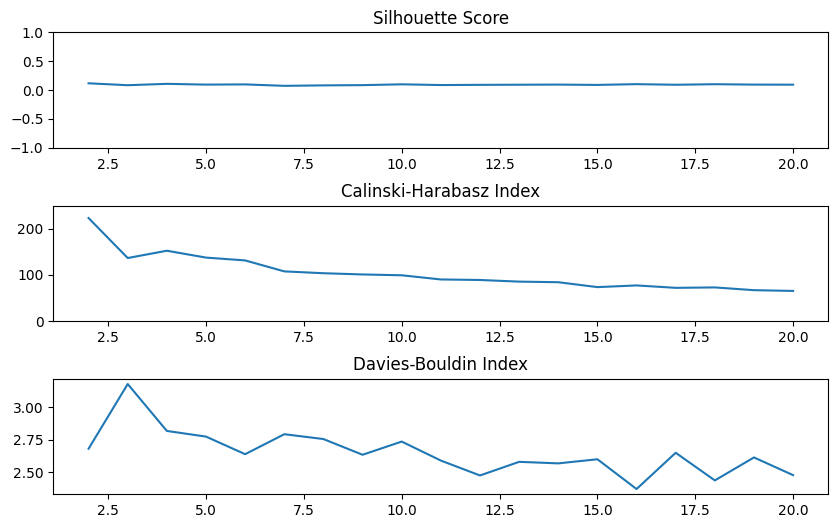

In [8]:
display_scores(acc1)

Well, our original runtime was 2.5 seconds, somewhat increased by measuring accuracy three times. Despite my for-loop architecture, this may yet be viable for the whole data set. The accuracy is fairly invariate for the Silhouette and Davies-Bouldin Indices, though less so for the latter test. The distinction probably suggests that there's probably very few data clusters for this particular champion. Calinski-Harabasz is moderately promising, but I've kind of just shopped around for what worked. The drawbacks of the method tend to be over-representing the efficacy of fitting convex clusters, which Kmeans tends to create. This would be a problem if I were comparing KMeans to other methods, but I'm not, so this is probably fine. That being said, since I'm not happy with this, I'm going to continue shopping around for methods to improve these scores. The first of which will be PCA, which really ought to not do anything, but might improve the runtime.

In [29]:
acc2 = measurement_testing(X=Xashe, count=19, PCAV=True)
acc2[:,1].max(),acc2[:,2].max(),acc2[:,3].max()

(np.float64(0.16229262743186887),
 np.float64(219.806785820826),
 np.float64(3.0366865829293044))

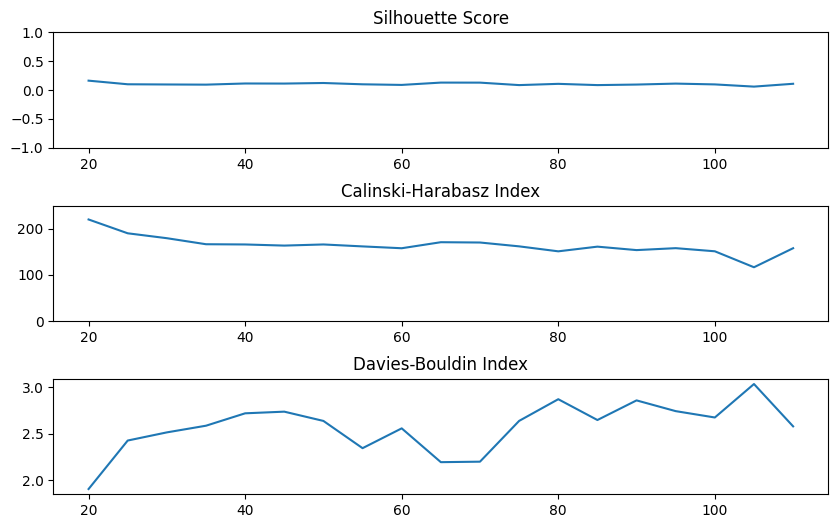

In [30]:
display_scores(acc2)

Well, it looks like fewer components is better, which makes sense since most champions shouldn't be building every item. With that information in hand, we'll see how it affects clustering. (this should ideally be different for each champion, but that'll take forever)

In [31]:
pca = PCA(20).fit(Xashe)
XashePCA = pca.transform(Xashe)
acc3=measurement_testing(XashePCA,19)

That didn't meaningfully change the run time.

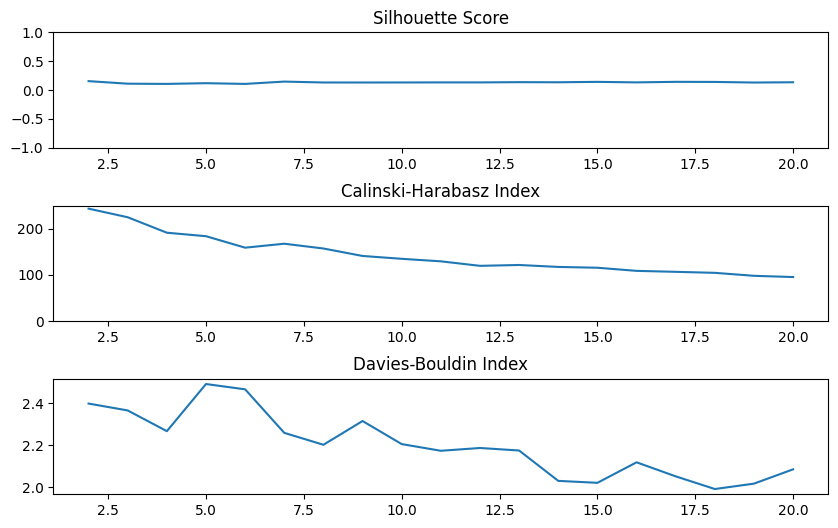

In [32]:
display_scores(acc3)

Now it seems like Davies-Bouldin doesn't really care about cluster count, which seems odd. But it's slightly increase the dynamic range of the Calinski-Harabasz Index, so I guess I'm okay with that. I'm not actually sure PCA makes sense on this data set, since the one-hot encoding means that the angles between dimensions is always 90 degrees, which makes principal components less interesting. What this must do is basically drop items that aren't in the top 20. To that effect, there are certain super common items which everyone buys. Deviations from that pattern would make for interesting clustering, but that deviation might not happen. So I'm gonna drop them and see what happens. 

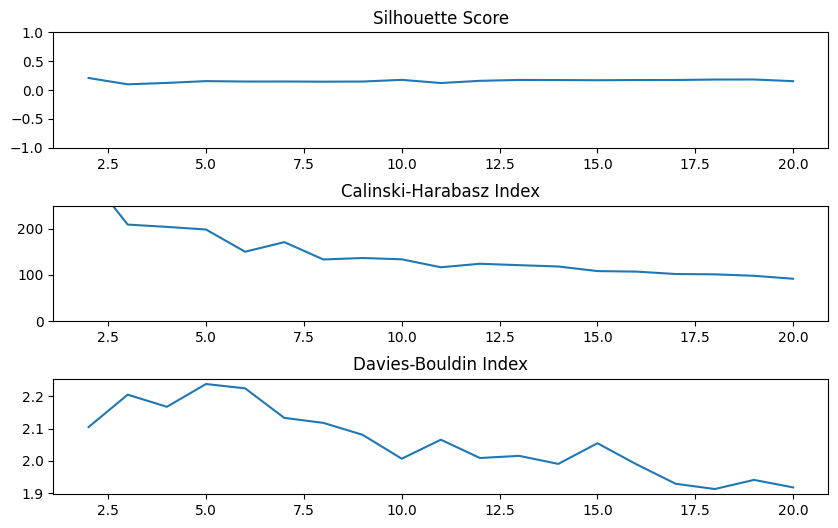

In [54]:
XasheRare = np.array(ashe.drop(columns=['0','1054','1055','1056','3006','3009','3020','3047','3111','1038','1042','1036','1043','1053','3340','3364','3363','KDA']).copy())
accRare = measurement_testing(XasheRare,19)
display_scores(accRare)

This seems a lot more promising for clustering, so I'm gonna go along with it.